<a href="https://colab.research.google.com/github/tigju/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
import numpy as np
pd.set_option("display.max_rows", 130)

In [7]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [8]:
df.isnull().sum()

Burrito             0
Date                0
Yelp              334
Google            334
Chips             395
Cost                7
Hunger              3
Mass (g)          399
Density (g/mL)    399
Length            138
Circum            140
Volume            140
Tortilla            0
Temp               20
Meat               14
Fillings            3
Meat:filling        9
Uniformity          2
Salsa              25
Synergy             2
Wrap                3
Unreliable        388
NonSD             414
Beef              242
Pico              263
Guac              267
Cheese            262
Fries             294
Sour cream        329
Pork              370
Chicken           400
Shrimp            400
Fish              415
Rice              385
Beans             386
Lettuce           410
Tomato            414
Bell peper        414
Carrots           420
Cabbage           413
Sauce             383
Salsa.1           414
Cilantro          406
Onion             404
Taquito           417
Pineapple 

In [0]:
df['Date'] = pd.to_datetime(df['Date'])

train = df[df['Date'].dt.year <= 2016]
validate = df[df['Date'].dt.year == 2017]
test = df[df['Date'].dt.year >= 2018]

In [10]:
train.shape, validate.shape, test.shape

((298, 59), (85, 59), (38, 59))

In [11]:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [0]:
#baseline predictions
majority_class = y_train.mode()[0]
y_pred_train = [majority_class]*len(y_train)

In [13]:
#baseline predictions
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred_train)

0.5906040268456376

In [26]:
y_validate = validate[target]
y_pred_val = [majority_class]*len(y_validate)
accuracy_score(y_validate, y_pred_val)

0.5529411764705883

In [27]:
train.describe(exclude='number')

,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,298,298,22,27,5,168,143,139,149,119,85,43,20,20,5,33,32,11,7,7,1,7,37,6,15,17,4,7,1,4,4,1,4,3,3,2,13,2,1,298
unique,5,110,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,2,1,2
top,California,2016-08-30 00:00:00,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,False
freq,118,29,19,27,3,130,115,101,121,97,63,29,19,17,3,24,24,9,5,4,1,5,33,5,9,9,3,5,1,4,4,1,4,3,3,2,13,1,1,176
first,NaN,2011-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-12-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
features = ['Tortilla', 'Meat', 'Cheese', 'Guac', 'Beans', 'Salsa', 'Wrap', 'Fries', 'Avocado', 'Chile relleno']
features

['Tortilla',
 'Meat',
 'Cheese',
 'Guac',
 'Beans',
 'Salsa',
 'Wrap',
 'Fries',
 'Avocado',
 'Chile relleno']

In [115]:
# features = train.columns.drop([target, 'Date', 'Burrito'])
# features

Index(['Yelp', 'Google', 'Chips', 'Cost', 'Hunger', 'Mass (g)',
       'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla', 'Temp',
       'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy',
       'Wrap', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac', 'Cheese',
       'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice',
       'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots', 'Cabbage',
       'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham',
       'Chile relleno', 'Nopales', 'Lobster', 'Queso', 'Egg', 'Mushroom',
       'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini'],
      dtype='object')

In [0]:
# Arrange X feature matrices (already did y target vectors)
X_train = train[features]
X_val = validate[features]

In [125]:
X_train

,Tortilla,Meat,Cheese,Guac,Beans,Salsa,Wrap,Fries,Avocado,Chile relleno
0,3.0,3.0,x,x,NaN,4.0,4.0,x,NaN,NaN
1,2.0,2.5,x,x,NaN,3.5,5.0,x,NaN,NaN
2,3.0,2.5,NaN,x,NaN,3.0,5.0,NaN,NaN,NaN
3,3.0,3.5,NaN,x,NaN,4.0,5.0,NaN,NaN,NaN
4,4.0,4.0,x,NaN,NaN,2.5,4.0,x,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
296,4.0,2.0,NaN,NaN,NaN,3.0,4.5,NaN,NaN,NaN
297,4.5,2.0,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN
298,3.5,3.0,X,NaN,NaN,2.2,4.5,X,NaN,NaN
299,4.0,2.0,NaN,X,NaN,2.0,4.0,NaN,NaN,NaN


In [0]:
import category_encoders as ce 
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV


In [127]:
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)
X_train_enc.shape, X_val_enc.shape

((298, 20), (85, 20))

In [0]:
# # prevent dividing by zero
# np.seterr(divide='ignore', invalid='ignore')

# selector = SelectKBest(score_func=f_regression, k=15)
# X_train_kbest = selector.fit_transform(X_train_enc, y_train)
# X_test_kbest = selector.transform(X_val_enc)

In [128]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_enc)
X_val_imputed = imputer.transform(X_val_enc)
X_train_imputed.shape, X_val_imputed.shape

((298, 20), (85, 20))

In [129]:
X_train_imputed

array([[3. , 3. , 1. , ..., 0. , 1. , 0. ],
       [2. , 2.5, 1. , ..., 0. , 1. , 0. ],
       [3. , 2.5, 0. , ..., 0. , 1. , 0. ],
       ...,
       [3.5, 3. , 0. , ..., 0. , 1. , 0. ],
       [4. , 2. , 0. , ..., 0. , 1. , 0. ],
       [3.6, 4. , 0. , ..., 0. , 1. , 0. ]])

In [0]:
X_train_imp = pd.DataFrame(X_train_imputed, columns=X_train_enc.columns)
X_val_imp = pd.DataFrame(X_val_imputed, columns = X_val_enc.columns)

In [131]:
X_val_imp.head()

,Tortilla,Meat,Cheese_x,Cheese_nan,Cheese_X,Guac_x,Guac_nan,Guac_X,Beans_nan,Beans_x,Beans_X,Salsa,Wrap,Fries_x,Fries_nan,Fries_X,Avocado_nan,Avocado_x,Chile relleno_nan,Chile relleno_x
0,4.0,4.000000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.5,4.5,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,4.0,3.551215,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.2,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,4.100000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.3,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,3.5,4.000000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,4.8,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,2.5,3.000000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [0]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_imp)
X_val_sc = scaler.transform(X_val_imp)

In [0]:
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_enc.columns)
X_val_sc = pd.DataFrame(X_val_sc, columns = X_val_enc.columns)

In [134]:
model = LogisticRegressionCV()
model.fit(X_train_sc, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [135]:
print(f'Validation score: {model.score(X_val_sc, y_validate)}')

Validation score: 0.7529411764705882


In [136]:
coefs = pd.Series(model.coef_[0], X_train_sc.columns)
coefs

Tortilla             0.492019
Meat                 0.896253
Cheese_x             0.022474
Cheese_nan           0.038242
Cheese_X            -0.103359
Guac_x               0.092623
Guac_nan             0.002437
Guac_X              -0.135087
Beans_nan            0.143437
Beans_x             -0.148383
Beans_X             -0.024931
Salsa                0.466966
Wrap                 0.090086
Fries_x              0.044730
Fries_nan           -0.002054
Fries_X             -0.076304
Avocado_nan          0.170384
Avocado_x           -0.170384
Chile relleno_nan   -0.090499
Chile relleno_x      0.090499
dtype: float64

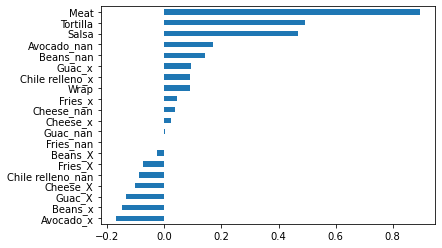

In [137]:
coefs.sort_values().plot.barh();

In [138]:
X_test = test[features]
X_test_enc = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_enc)
X_test_scaled = scaler.transform(X_test_imputed)
X_test_scaled

array([[ 1.29062863e+00,  1.69789203e+00,  1.20946679e+00,
        -1.00000000e+00, -3.22030594e-01,  1.39660125e+00,
        -1.06952555e+00, -3.82300727e-01,  3.46843988e-01,
        -2.95958174e-01, -1.66090960e-01, -3.46697110e-01,
         8.99678662e-01,  1.43950163e+00, -1.22645900e+00,
        -2.82329851e-01,  2.13574425e-01, -2.13574425e-01,
         1.16642369e-01, -1.16642369e-01],
       [ 6.62698293e-01,  5.25949777e-01, -8.26810631e-01,
         1.00000000e+00, -3.22030594e-01, -7.16023991e-01,
         9.34994030e-01, -3.82300727e-01,  3.46843988e-01,
        -2.95958174e-01, -1.66090960e-01, -3.46697110e-01,
         8.99678662e-01, -6.94684867e-01,  8.15355425e-01,
        -2.82329851e-01,  2.13574425e-01, -2.13574425e-01,
         1.16642369e-01, -1.16642369e-01],
       [-5.93162383e-01, -1.81793472e+00,  1.20946679e+00,
        -1.00000000e+00, -3.22030594e-01, -7.16023991e-01,
         9.34994030e-01, -3.82300727e-01, -2.88314065e+00,
         3.37885582e+00, -1.6

In [158]:
y_pred = model.predict(X_test_scaled)
y_pred

array([ True,  True, False,  True, False,  True,  True,  True, False,
        True,  True, False, False, False,  True,  True,  True, False,
       False, False, False,  True, False, False,  True,  True, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True, False])